In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_price = pd.read_csv("pricecatcher_2023-01.csv").dropna(axis=0)
df_premise = pd.read_csv("lookup_premise.csv").dropna(axis=0)
df_item = pd.read_csv("lookup_item.csv").dropna(axis=0)

combine = [df_item, df_premise, df_price]
df1= pd.merge(df_price, df_premise, on="premise_code", how="left")
df = pd.merge(df1, df_item, on="item_code", how="left")

try:
    df.drop(columns=["item_code","premise_code"], axis=1, inplace=True)
except:
    print("columns already dropped")

In [3]:
df = df.dropna()
df["item_with_unit"] = df["item_group"] + " " + df["unit"]


C:\Users\Ahmad\AppData\Local\Temp\ipykernel_2208\2159576777.py:14: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  iter_columns = df_item_by_state.drop(columns=["state"],axis=1).columns.tolist()


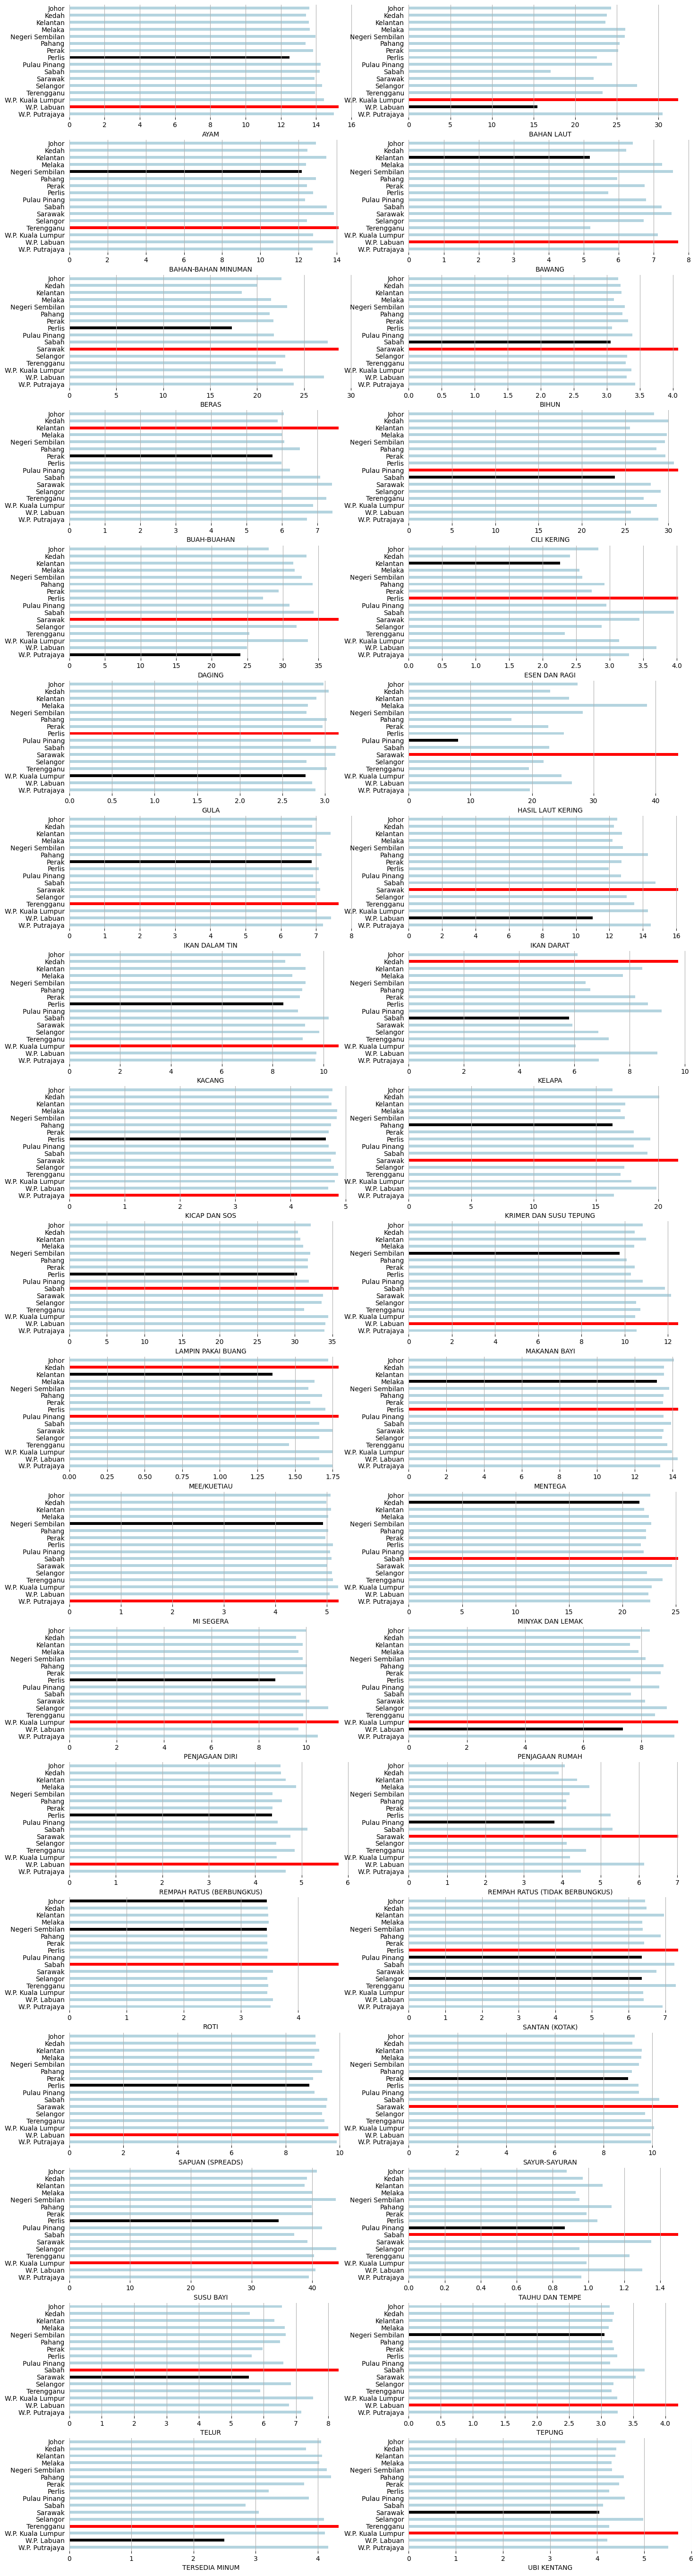

In [4]:
#Group item by state and their mean price for each item category
df_item_by_state = df.groupby(["state","item_category"])[["price"]].mean().round(2).unstack().reset_index()

#For Nan value, we just gonna fill them with, the mean of the mean in particular column
def fillna_with_mean(df):
    for column in df_item_by_state.columns:
        if df_item_by_state[column].isnull().any():
            mean_price = df_item_by_state[column].mean().round(2)
            df_item_by_state[column] = df_item_by_state[column].fillna(mean_price)

fillna_with_mean(df_item_by_state) #run the function

# GRAPH 
iter_columns = df_item_by_state.drop(columns=["state"],axis=1).columns.tolist() 
fig, axes = plt.subplots(nrows=19, ncols=2, figsize=(17, 70))
axes = axes.ravel()

for idx,column in enumerate(iter_columns):
    sns.barplot(x=column, y="state", 
                data=df_item_by_state, 
                color="lightblue",
                width=0.4,
                ax=axes[idx]
                )
    bar_heights = []
    max_country = []
    min_country = []

    #STEPS TO COLOR THE MAX VALUE BAR AS RED
    # iterate through every bar in plot, get all the width(if vertical use get_height()) and store in bar_heights
    for patch in axes[idx].patches:
        bar_heights.append(patch.get_width())
    
    # iterate again, find the maximum bar and color as red
    for patch in axes[idx].patches:
        if patch.get_width() == max(bar_heights):
            # print(bar_heights)
            patch.set_facecolor("red")
            # max_country.append(patch.get_label())

        if patch.get_width() == min(bar_heights):
            patch.set_facecolor("black")
            # min_country.append(patch.get_label())

    axes[idx].xaxis.grid(True)
    axes[idx].yaxis.grid(False)
    axes[idx].set_ylabel('')
    axes[idx].set_xlabel(f"{column[1]}")
    axes[idx].tick_params(left=False)

sns.despine(left=True, top=True, bottom=True)

In [5]:
# FIND 5 CHEAPEST STORE TO BUY ITEMS IN YOUR STATE
def where_to_buy(state, items):
    state = state.capitalize()
    items = [item.upper() for item in items]

# list_store = df[(df["item_category"].isin(["AYAM","GULA"])) & (df["state"] == "Perak")].\
    list_store = df[(df["item_category"].isin(items)) & (df["state"] == state)].\
    groupby(["item_category","premise"])["price"].min().unstack().dropna(axis=1).reset_index().drop(columns=["item_category"])


    for idx,row in list_store.iterrows():
        list_store.loc["sum"] = list_store.loc[:idx].sum()

    store = list_store.loc["sum"].sort_values().index[:5]
    min_price = list_store.loc["sum"].sort_values()[:5]

    result = pd.DataFrame({'stores': store.to_list(), 'total_price': min_price.to_list()})

    return result

    # return result
available_grocery = [
"AYAM","DAGING","BUAH-BUAHAN","BAHAN LAUT","SAYUR-SAYURAN","TELUR","BAWANG","KACANG","IKAN DALAM TIN","KICAP DAN SOS",
"TEPUNG","UBI KENTANG","GULA","SANTAN (KOTAK)","CILI KERING","SUSU BAYI","PENJAGAAN DIRI","MAKANAN BAYI","MENTEGA",
"LAMPIN PAKAI BUANG"
]
where_to_buy("terengganu",["GULA","AYAM","SANTAN (KOTAK)","CILI KERING"])


,stores,total_price
0,PASARAYA XIRI KUALA BERANG SDN BHD,30.71
1,PXR Bukit Tunggal,32.28
2,PASARAYA XIRI GONG DATOK,32.33
3,PASARAYA PXR WAKAF TAPAI,32.33
4,Q-MART,33.15
